In [1]:
# Import!
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Hyperparameters
MAX_IMAGE_SIZE = 512

# Optimizer
OPTIMIZER = 'adam' #or 'lbfgs'
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3
NUM_ITER = 500
SHOW_ITER = 100

# Image Files
INIT_IMAGE = 'random' # or 'content'
PRESERVE_COLOR = 'False' # 'False'
PIXEL_CLIP = 'True' # or False - Clipping produces better images
CONTENT_PATH = 'drive/MyDrive/style_transfer/images/1-content.jpg'
STYLE_1_PATH = 'drive/MyDrive/style_transfer/images/1-style_1.jpg'
STYLE_2_PATH = 'drive/MyDrive/style_transfer/images/1-style_2.jpg'
VGG19_PATH = 'drive/MyDrive/style_transfer/models/vgg19-d01eb7cb.pth'
POOL = 'max'

In [4]:
# Print the device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Utils
# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()
    
# Save Image as out{num_iterms}.png
def saveimg(img, iters):
    if (PIXEL_CLIP=='True'):
        img = img.clip(0, 255)
    cv2.imwrite('out'+str(iters)+'.png', img)
    
# Color transfer
def transfer_color(src, dest):
    if (PIXEL_CLIP=='True'):
        src, dest = src.clip(0,255), dest.clip(0,255)
        
    # Resize src to dest's size
    H,W,_ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
    
    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  #4 Convert new image from YIQ back to BGR

In [6]:
# Preprocessing
def itot(img):
    # Rescale the image
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])
    
    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # Subtract the means
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize_t(itot_t(img)*255)
    
    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    # Add the means
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])
    
    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

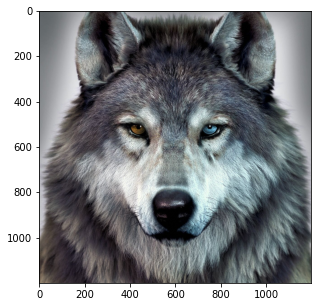

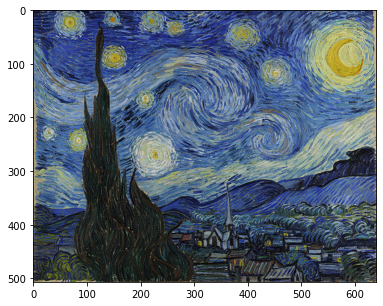

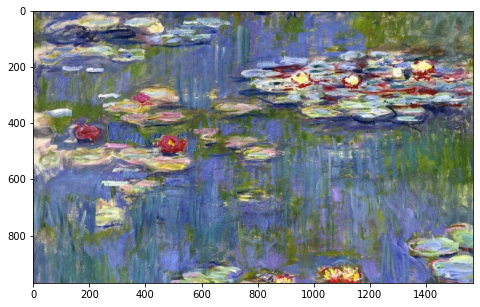

In [7]:
content_img = load_image(CONTENT_PATH)
style_1_img = load_image(STYLE_1_PATH)  
style_2_img = load_image(STYLE_2_PATH)    

# Show Images
show(content_img)
show(style_1_img)
show(style_2_img)

In [8]:
# Load VGG19 Skeleton
vgg = models.vgg19(pretrained=False)

# Load pretrained weights
vgg.load_state_dict(torch.load(VGG19_PATH), strict=False)

# Change Pooling Layer
def pool_(model, pool='avg'):
    if (pool=='avg'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1
    elif (pool=='max'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1
            
    return model

#vgg.features = pool_(vgg.features, POOL)

# Extract only the 'features' network, 
# 'classifier' network is not needed
model = copy.deepcopy(vgg.features)
model.to(device)

# Turn-off unnecessary gradient tracking
for param in model.parameters():
    param.requires_grad = False

In [9]:
mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    loss = mse_loss(g, c)
    return loss
    
def style_loss(g, s1, s2):
    c1,c2 = g.shape
    loss_1 = mse_loss(g, s1)
    loss_2 = mse_loss(g, s2)
    loss = 0.5*loss_1 + 0.5*loss_2
    return loss / (c1**2) # Divide by square of channels

def tv_loss(c):
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

In [10]:
# VGG Forward Pass
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }
    
    # Get features
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name=='22'):   # relu4_2
                features[layers[name]] = x
            elif (name=='31'): # relu5_2
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)
                
            # Terminate forward pass
            if (name == '35'):
                break
            
    return features

In [11]:
# Generate Initial Image
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if (init_image=='random'):
        #tensor = torch.randn(C, H, W).mul(torch.std(content_tensor.clone().cpu())/255).unsqueeze(0)
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()
    
    return tensor

# Convert Images to Tensor
content_tensor = itot(content_img).to(device)
style_1_tensor = itot(style_1_img).to(device)
style_2_tensor = itot(style_2_img).to(device)
g = initial(content_tensor, init_image=INIT_IMAGE)
g = g.to(device).requires_grad_(True)

In [12]:
def stylize(iteration=NUM_ITER):     
    # Get features representations/Forward pass
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0} 
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    c_feat = get_features(model, content_tensor)
    s_1_feat = get_features(model, style_1_tensor)
    s_2_feat = get_features(model, style_2_tensor)
    
    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(model, g)

            # Compute Losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_1_feat[j], s_2_feat[j])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(g.clone().detach())
            total_loss = c_loss + s_loss + t_loss

            # Backprop
            total_loss.backward(retain_graph=True)
            # Print Loss, show and save image
            i[0]+=1
            if (((i[0] % SHOW_ITER) == 1) or (i[0]==NUM_ITER)):
                print("Style Loss: {} Content Loss: {} TV Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), t_loss, total_loss.item()))
                if (PRESERVE_COLOR=='True'):
                    g_ = transfer_color(ttoi(content_tensor.clone().detach()), ttoi(g.clone().detach()))
                else:
                    g_ = ttoi(g.clone().detach())
                show(g_)
                saveimg(g_, i[0]-1)
                plt.show()
            
            return (total_loss)
        
        # Weight/Pixel update
        optimizer.step(closure)

    return g

Style Loss: 63301432.0 Content Loss: 1673891.5 TV Loss: 1.7727669477462769 Total Loss : 64975324.0


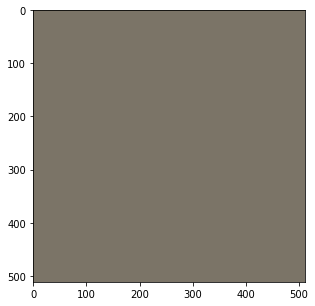

Style Loss: 3675062.5 Content Loss: 855103.4375 TV Loss: 30541.56640625 Total Loss : 4560707.5


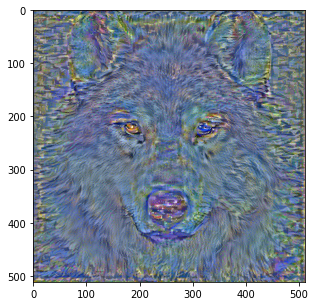

Style Loss: 3671505.75 Content Loss: 696895.6875 TV Loss: 30401.779296875 Total Loss : 4398803.5


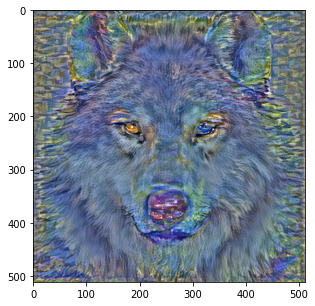

Style Loss: 3663765.25 Content Loss: 642721.9375 TV Loss: 30694.99609375 Total Loss : 4337182.0


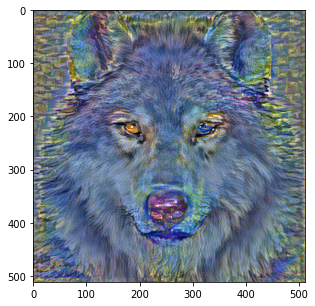

Style Loss: 3620935.5 Content Loss: 623420.375 TV Loss: 31102.6328125 Total Loss : 4275458.5


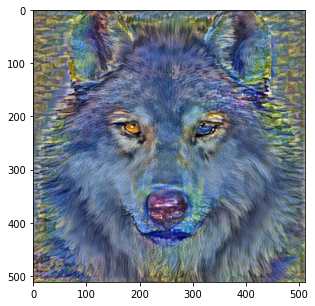

Style Loss: 3797569.25 Content Loss: 756482.75 TV Loss: 33393.4921875 Total Loss : 4587445.5


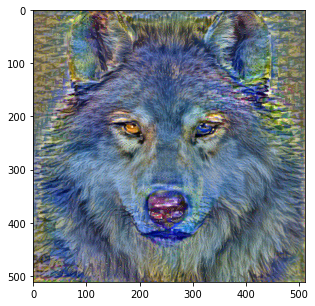

In [13]:
"""
Define Optimizer
The optimizer minimizes the total loss by updating the tensor 'g'.
"""
if (OPTIMIZER=='lbfgs'):
    optimizer = optim.LBFGS([g])
else:
    optimizer = optim.Adam([g], lr=ADAM_LR)
    
# Stylize!
out = stylize(iteration=NUM_ITER)